Introducción y lectura de bases de datos.

En este primer informe nos proponemos hacer una primera aproximación a los resultados electorales obtenidos por el partido 3 en la Ciudad Autónoma de Buenos Aires y analizarlos en relación con ciertas variables sociodemográficas de la población, para así poder llegar a trazar un primer perfil del votante y ejecutar acciones de campaña en ese sentido. Con este objetivo, nos dirigimos a hacer lectura de la información obtenida. 

In [1]:
from itertools import count
from statistics import geometric_mean
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt


Como primer paso, abrimos las bases de datos "resultados_paso" y "circuitos_electorales"(base descargada del GCBA que usaremos para vincular circuitos electorales con comunas).

In [2]:
resultados_paso = pd.read_csv(
    "paso_x_partido.csv" "",
    delimiter=",",  # delimitador ',',';','|','\t'
    header=0,  # número de fila como nombre de columna
    names=None,  # nombre de las columnas (ojo con header)
    index_col=0,  # que col es el índice
    usecols=None,  # que col usar. Ej: [0, 1, 2], ['foo', 'bar', 'baz']
    dtype=None,  # Tipo de col {'a': np.int32, 'b': str}
    skiprows=None,  # saltear filas al inicio
    skipfooter=0,  # saltear filas al final
    nrows=None,  # n de filas a leer
    decimal=".",  # separador de decimal. Ej: ',' para EU dat
    quotechar='"',  # char para reconocer str
    encoding=None,
)

resultados_paso  # archivos con tilde y ñ por lo general utilizan "utf-8" etc
#%%
comunas = pd.read_csv(
    "circuitos-electorales.csv",
    delimiter=",",  # delimitador ',',';','|','\t'
    header=0,  # número de fila como nombre de columna
    names=None,  # nombre de las columnas (ojo con header)
    index_col=0,  # que col es el índice
    usecols=None,  # que col usar. Ej: [0, 1, 2], ['foo', 'bar', 'baz']
    dtype=None,  # Tipo de col {'a': np.int32, 'b': str}
    skiprows=None,  # saltear filas al inicio
    skipfooter=0,  # saltear filas al final
    nrows=None,  # n de filas a leer
    decimal=".",  # separador de decimal. Ej: ',' para EU dat
    quotechar='"',  # char para reconocer str
    encoding=None,
)

Vinculamos circuitos electorales con comunas.

In [3]:
circuito_comuna = comunas[["COMUNA", "CIRCUITO_N", "BARRIO"]].rename(
    columns={"CIRCUITO_N": "circuito"}
)
circuito_comuna = circuito_comuna.sort_values(by=["circuito"])
circuito_comuna = circuito_comuna.reset_index(drop=True)

tabla_final = pd.merge(
    resultados_paso, circuito_comuna, on="circuito", how="outer", indicator=True
)
tabla_final

,circuito,urna,pp1,pp2,pp3,pp4,nv,COMUNA,BARRIO,_merge
0,1,0,64,74,49,50,63,1,SAN TELMO,both
1,1,1,79,81,44,36,60,1,SAN TELMO,both
2,1,2,72,74,55,34,65,1,SAN TELMO,both
3,1,3,82,80,37,38,63,1,SAN TELMO,both
4,1,4,64,87,57,28,64,1,SAN TELMO,both
...,...,...,...,...,...,...,...,...,...,...
7634,167,32,76,46,56,66,56,15,AGRONOMIA,both
7635,167,33,62,59,51,57,71,15,AGRONOMIA,both
7636,167,34,63,52,51,69,65,15,AGRONOMIA,both
7637,167,35,68,66,51,64,51,15,AGRONOMIA,both


Pasamos a analizar la distribución de votos que tuvo cada candidato. Esto es, sobre el 100% que obtuvo, por ejemplo, el candidato 3, se analiza la distribución de ese total que tuvo por comunas. En este caso, el porcentaje de votos es analizado para cada candidato de forma aislada.

In [4]:
distrib_candidatos = (
    tabla_final[["COMUNA", "pp1", "pp2", "pp3", "pp4", "nv", "BARRIO",]]
    .groupby(["COMUNA"])
    .sum()
    .transform(lambda x: (x + 0.0) / x.sum() * 100)
)
distrib_candidatos

/var/folders/l2/dnldqmpn36q_2tbrlwy8wnw40000gn/T/ipykernel_966/2591842797.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .sum()


,pp1,pp2,pp3,pp4,nv
COMUNA,,,,,
1,7.232794,9.450333,5.152216,4.998396,6.698759
2,4.439748,4.805121,7.125770,6.884241,5.815161
3,7.573100,7.902294,5.214219,5.623694,6.537122
4,8.411547,9.968829,4.995669,5.114962,7.105827
5,6.772836,6.259406,6.069294,6.360912,6.419809
6,5.903311,4.896027,7.384997,7.114055,6.272286
7,7.524485,8.139089,7.119394,6.815452,7.480038
8,6.617667,9.496991,3.263092,3.665963,5.781864
9,6.131736,5.339826,5.227412,5.180434,5.415370


A continuación, se expresa la cantidad de votos que obtuvo cada candidato, agrupado por comuna y por circuito electoral.

In [5]:
total_votos_x_comunas = (
    tabla_final[["COMUNA","circuito", "pp1", "pp2", "pp3", "pp4", "nv", "BARRIO"]]
    .groupby(["COMUNA","circuito"])
    .sum()
)
total_votos_x_comunas

/var/folders/l2/dnldqmpn36q_2tbrlwy8wnw40000gn/T/ipykernel_966/2914924009.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .sum()


pp1   pp2   pp3   pp4    nv
COMUNA circuito                              
1      1         1955  2113  1237  1182  1655
       2         2005  2122  1220  1390  1618
       3          600   812   286   383   509
       4          336   371   140   196   240
       5         4053  4071  3029  2929  3443
...               ...   ...   ...   ...   ...
15     163       2290  2276  2040  2174  2174
       164       2095  1900  2039  2106  2119
       165       3618  3588  3157  3399  3501
       166       2970  2569  2773  2878  2798
       167       2358  2033  2091  2317  2250

[167 rows x 5 columns]

Entonces, se agrega una columna para expresar la cantidad de votantes, también agrupado por comuna y por circuito electoral.

In [6]:
total_votos_x_comunas = total_votos_x_comunas.assign(
    total=lambda x: (x["pp1"] + x["pp2"] + x["pp3"] + x["pp4"] + x["nv"])
)
total_votos_x_comunas

pp1   pp2   pp3   pp4    nv  total
COMUNA circuito                                     
1      1         1955  2113  1237  1182  1655   8142
       2         2005  2122  1220  1390  1618   8355
       3          600   812   286   383   509   2590
       4          336   371   140   196   240   1283
       5         4053  4071  3029  2929  3443  17525
...               ...   ...   ...   ...   ...    ...
15     163       2290  2276  2040  2174  2174  10954
       164       2095  1900  2039  2106  2119  10259
       165       3618  3588  3157  3399  3501  17263
       166       2970  2569  2773  2878  2798  13988
       167       2358  2033  2091  2317  2250  11049

[167 rows x 6 columns]

Ahora calculamos el porcentaje de votos que obtuvo cada candidato, agrupando por comuna y por circuito electoral.

In [7]:
porcentaje_votos_x_comunas = total_votos_x_comunas.transform(
    (lambda x: (x + 0.0) / x["total"] * 100), axis=1
)
porcentaje_votos_x_comunas

pp1        pp2        pp3        pp4         nv  total
COMUNA circuito                                                              
1      1         24.011299  25.951855  15.192827  14.517318  20.326701  100.0
       2         23.997606  25.397965  14.602035  16.636744  19.365649  100.0
       3         23.166023  31.351351  11.042471  14.787645  19.652510  100.0
       4         26.188620  28.916602  10.911925  15.276695  18.706157  100.0
       5         23.126961  23.229672  17.283880  16.713267  19.646220  100.0
...                    ...        ...        ...        ...        ...    ...
15     163       20.905605  20.777798  18.623334  19.846631  19.846631  100.0
       164       20.421094  18.520324  19.875232  20.528317  20.655035  100.0
       165       20.958119  20.784336  18.287667  19.689509  20.280368  100.0
       166       21.232485  18.365742  19.824135  20.574778  20.002860  100.0
       167       21.341298  18.399855  18.924790  20.970224  20.363834  100.0

[167 rows x 6 columns]

In [8]:
porcentaje_votos_x_comunas.reset_index(inplace=True)

In [9]:
porcentaje_votos_x_comunas

,COMUNA,circuito,pp1,pp2,pp3,pp4,nv,total
0,1,1,24.011299,25.951855,15.192827,14.517318,20.326701,100.0
1,1,2,23.997606,25.397965,14.602035,16.636744,19.365649,100.0
2,1,3,23.166023,31.351351,11.042471,14.787645,19.652510,100.0
3,1,4,26.188620,28.916602,10.911925,15.276695,18.706157,100.0
4,1,5,23.126961,23.229672,17.283880,16.713267,19.646220,100.0
...,...,...,...,...,...,...,...,...
162,15,163,20.905605,20.777798,18.623334,19.846631,19.846631,100.0
163,15,164,20.421094,18.520324,19.875232,20.528317,20.655035,100.0
164,15,165,20.958119,20.784336,18.287667,19.689509,20.280368,100.0
165,15,166,21.232485,18.365742,19.824135,20.574778,20.002860,100.0


En vistas de hacer más fácil el análisis, ordenamos los circuitos electorales en función del desempeño de nuestro candidato.

In [10]:
porcentaje_orden = porcentaje_votos_x_comunas.sort_values(["pp3"], ascending=False)
porcentaje_orden

,COMUNA,circuito,pp1,pp2,pp3,pp4,nv,total
20,2,21,14.911404,9.859155,32.975920,21.899137,20.354384,100.0
143,13,144,13.819275,9.752255,32.120865,23.857941,20.449663,100.0
19,2,20,14.582606,14.093608,30.387705,20.817324,20.118757,100.0
137,13,138,13.913556,10.998035,30.133595,24.632613,20.322200,100.0
154,14,155,13.342616,12.137507,29.791627,25.000000,19.728250,100.0
...,...,...,...,...,...,...,...,...
75,7,76,19.127813,41.719370,8.817473,9.957347,20.377997,100.0
43,4,44,21.073095,48.367030,4.406428,5.728357,20.425091,100.0
44,4,45,20.645574,50.079898,3.739214,5.512943,20.022371,100.0
5,1,6,17.301650,54.588898,3.698612,4.660906,19.749935,100.0


Abrimos las bases de datos del censo.

In [11]:
hogar = pd.read_csv("censo/hogar.csv", sep=",")

#
vivienda = pd.read_csv("censo/vivienda.csv", sep=",")

#
persona = pd.read_csv("censo/persona.csv", sep=",")

#
prov = pd.read_csv("censo/prov.csv", sep=",")

# 
radio = pd.read_csv("censo/radio.csv")

# 
frac = pd.read_csv("censo/frac.csv")

Utilizamos la siguiente linea de codigo para vincular las comunas, con las personas, viviendas y hogares.

In [12]:
dpto = pd.read_csv("censo/dpto.csv")
dpto = dpto[["DPTO_REF_ID", "NOMDPTO"]]
#dpto
# %%
dpto_frac = pd.merge(dpto, frac, on="DPTO_REF_ID", how="left")
dpto_frac.groupby = ["NOMDPTO"]
#dpto_frac
# %%
dpto_frac_radio = pd.merge(dpto_frac, radio, on="FRAC_REF_ID", how="right")
#dpto_frac_radio

# %%
dpto_frac_radio_vivienda = pd.merge(
    dpto_frac_radio, vivienda, on="RADIO_REF_ID", how="right", indicator=True
)
dpto_frac_radio_vivienda.rename(columns={"DPTO_REF_ID": "COMUNA"}, inplace=True)
#dpto_frac_radio_vivienda
#%%

# %%
#dpto_frac_radio_vivienda
# %%
hogarSUPREMO = pd.merge(
    dpto_frac_radio_vivienda, hogar, on="VIVIENDA_REF_ID", how="right"
)

En la siguiente variable, se almacena por comuna el cruce de todas las variables de hogares y viviendas.

In [13]:
hogarSUPREMO

,COMUNA,NOMDPTO,FRAC_REF_ID,IDFRAC,RADIO_REF_ID,IDRADIO,VIVIENDA_REF_ID,TIPVV,V01,V02,...,H15,H16,H19A,H19B,H19C,H19D,PROP,INDHAC,TOTPERS,ALGUNBI
0,1,Comuna 01 ...,1,1,1,1,1,1,1,1,...,2,2,1,2,1,2,5,1,1,0
1,1,Comuna 01 ...,1,1,1,1,1,1,1,1,...,1,2,1,1,1,1,1,1,1,0
2,1,Comuna 01 ...,1,1,1,1,1,1,1,1,...,3,5,1,1,1,1,1,1,2,0
3,1,Comuna 01 ...,1,1,1,1,1,1,1,1,...,3,5,1,1,1,1,5,6,8,1
4,1,Comuna 01 ...,1,1,1,1,2,1,7,1,...,5,5,1,1,2,1,6,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152594,15,Comuna 15 ...,351,21,3553,13,1426434,1,4,1,...,2,3,1,1,1,1,1,1,1,0
1152595,15,Comuna 15 ...,351,21,3553,13,1426435,1,4,1,...,1,2,1,2,2,1,1,1,1,0
1152596,15,Comuna 15 ...,351,21,3553,13,1426436,1,4,1,...,2,3,1,1,1,1,1,3,3,0
1152597,15,Comuna 15 ...,351,21,3553,13,1426437,2,0,0,...,0,0,0,0,0,0,0,7,0,2


En la siguiente variable, se almacena por comuna el cruce de todas las variables de hogares, viviendas y personas.

In [14]:
personaSUPREMO = pd.merge(hogarSUPREMO, persona, on="HOGAR_REF_ID", how="right")
personaSUPREMO

,COMUNA,NOMDPTO,FRAC_REF_ID,IDFRAC,RADIO_REF_ID,IDRADIO,VIVIENDA_REF_ID,TIPVV,V01,V02,...,P05,P06,P07,P12,EDADAGRU,EDADQUI,P08,P09,P10,CONDACT
0,1,Comuna 01 ...,1,1,1,1,1,1,1,1,...,1,0,1,2,2,13,2,4,2,1
1,1,Comuna 01 ...,1,1,1,1,1,1,1,1,...,1,0,1,1,2,10,2,4,1,1
2,1,Comuna 01 ...,1,1,1,1,1,1,1,1,...,1,0,1,1,3,14,2,7,2,1
3,1,Comuna 01 ...,1,1,1,1,1,1,1,1,...,1,0,1,1,2,13,2,6,1,3
4,1,Comuna 01 ...,1,1,1,1,1,1,1,1,...,2,221,1,1,2,5,1,4,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2890146,15,Comuna 15 ...,351,21,3553,13,1426438,2,0,0,...,1,0,1,0,3,20,2,2,1,0
2890147,15,Comuna 15 ...,351,21,3553,13,1426438,2,0,0,...,1,0,1,0,3,19,2,6,1,0
2890148,15,Comuna 15 ...,351,21,3553,13,1426438,2,0,0,...,1,0,1,0,3,17,2,2,1,0
2890149,15,Comuna 15 ...,351,21,3553,13,1426438,2,0,0,...,1,0,1,0,3,18,2,2,1,0


A continuación, analizamos la cantidad de personas censadas que efectivamente son votantes.

In [15]:
votantes = personaSUPREMO[personaSUPREMO["P03"] >= 18]
votantes

,COMUNA,NOMDPTO,FRAC_REF_ID,IDFRAC,RADIO_REF_ID,IDRADIO,VIVIENDA_REF_ID,TIPVV,V01,V02,...,P05,P06,P07,P12,EDADAGRU,EDADQUI,P08,P09,P10,CONDACT
0,1,Comuna 01 ...,1,1,1,1,1,1,1,1,...,1,0,1,2,2,13,2,4,2,1
1,1,Comuna 01 ...,1,1,1,1,1,1,1,1,...,1,0,1,1,2,10,2,4,1,1
2,1,Comuna 01 ...,1,1,1,1,1,1,1,1,...,1,0,1,1,3,14,2,7,2,1
3,1,Comuna 01 ...,1,1,1,1,1,1,1,1,...,1,0,1,1,2,13,2,6,1,3
4,1,Comuna 01 ...,1,1,1,1,1,1,1,1,...,2,221,1,1,2,5,1,4,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2890146,15,Comuna 15 ...,351,21,3553,13,1426438,2,0,0,...,1,0,1,0,3,20,2,2,1,0
2890147,15,Comuna 15 ...,351,21,3553,13,1426438,2,0,0,...,1,0,1,0,3,19,2,6,1,0
2890148,15,Comuna 15 ...,351,21,3553,13,1426438,2,0,0,...,1,0,1,0,3,17,2,2,1,0
2890149,15,Comuna 15 ...,351,21,3553,13,1426438,2,0,0,...,1,0,1,0,3,18,2,2,1,0


Análisis de los resultados electorales del partido 3.

A continuación, pasamos a hacer un análisis sobre la distribución de votos del partido 3 por circuito electoral. Para esto, vamos a generar un mapa que nos permita visualizar claramente esta distribución. Para esto, necesitamos de un geodataframe con los circuitos electorales de CABA.

In [16]:
caba_shp = gpd.read_file(
    "CABA.shp"
)
caba_shp["circuito"]=caba_shp["circuito"].apply(int)
caba_shp

,distrito,provincia,departamen,cabecera,circuito,indec_p,indec_d,geometry
0,01,Ciudad Autónoma de Buenos Aires,Comuna 1,Comuna 1,3,02,001,"POLYGON Z ((-6496304.252 -4084732.697 0.000, -..."
1,01,Ciudad Autónoma de Buenos Aires,Comuna 4,Comuna 4,45,02,004,"POLYGON Z ((-6501230.474 -4091702.182 0.000, -..."
2,01,Ciudad Autónoma de Buenos Aires,Comuna 3,Comuna 3,37,02,003,"POLYGON Z ((-6501166.688 -4087904.826 0.000, -..."
3,01,Ciudad Autónoma de Buenos Aires,Comuna 1,Comuna 1,18,02,001,"POLYGON Z ((-6498832.986 -4088373.028 0.000, -..."
4,01,Ciudad Autónoma de Buenos Aires,Comuna 13,Comuna 13,141,02,013,"POLYGON Z ((-6503862.400 -4078547.361 0.000, -..."
...,...,...,...,...,...,...,...,...
162,01,Ciudad Autónoma de Buenos Aires,Comuna 13,Comuna 13,135,02,013,"POLYGON Z ((-6507834.614 -4077215.626 0.000, -..."
163,01,Ciudad Autónoma de Buenos Aires,Comuna 14,Comuna 14,149,02,014,"POLYGON Z ((-6503253.371 -4080723.227 0.000, -..."
164,01,Ciudad Autónoma de Buenos Aires,Comuna 9,Comuna 9,101,02,009,"POLYGON Z ((-6515182.479 -4090061.116 0.000, -..."
165,01,Ciudad Autónoma de Buenos Aires,Comuna 10,Comuna 10,102,02,010,"POLYGON Z ((-6514598.831 -4088679.114 0.000, -..."


Pasamos a unir el geodataframe de los circuitos electorales de CABA con el dataframe de los resultados electorales.

In [17]:
caba_votos_shp= pd.merge(caba_shp,porcentaje_votos_x_comunas, on="circuito", how="inner")
caba_votos_shp=caba_votos_shp.sort_values("circuito")
caba_votos_shp.reset_index(inplace=True)
caba_votos_shp

,index,distrito,provincia,departamen,cabecera,circuito,indec_p,indec_d,geometry,COMUNA,pp1,pp2,pp3,pp4,nv,total
0,7,01,Ciudad Autónoma de Buenos Aires,Comuna 1,Comuna 1,1,02,001,"POLYGON Z ((-6497294.216 -4088142.493 0.000, -...",1,24.011299,25.951855,15.192827,14.517318,20.326701,100.0
1,8,01,Ciudad Autónoma de Buenos Aires,Comuna 1,Comuna 1,2,02,001,"POLYGON Z ((-6498537.655 -4087740.684 0.000, -...",1,23.997606,25.397965,14.602035,16.636744,19.365649,100.0
2,0,01,Ciudad Autónoma de Buenos Aires,Comuna 1,Comuna 1,3,02,001,"POLYGON Z ((-6496304.252 -4084732.697 0.000, -...",1,23.166023,31.351351,11.042471,14.787645,19.652510,100.0
3,16,01,Ciudad Autónoma de Buenos Aires,Comuna 1,Comuna 1,4,02,001,"POLYGON Z ((-6497398.411 -4087025.705 0.000, -...",1,26.188620,28.916602,10.911925,15.276695,18.706157,100.0
4,5,01,Ciudad Autónoma de Buenos Aires,Comuna 1,Comuna 1,5,02,001,MULTIPOLYGON Z (((-6497185.903 -4082052.692 0....,1,23.126961,23.229672,17.283880,16.713267,19.646220,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,161,01,Ciudad Autónoma de Buenos Aires,Comuna 15,Comuna 15,163,02,015,"POLYGON Z ((-6505348.070 -4083866.211 0.000, -...",15,20.905605,20.777798,18.623334,19.846631,19.846631,100.0
163,157,01,Ciudad Autónoma de Buenos Aires,Comuna 15,Comuna 15,164,02,015,"POLYGON Z ((-6507652.050 -4084945.661 0.000, -...",15,20.421094,18.520324,19.875232,20.528317,20.655035,100.0
164,152,01,Ciudad Autónoma de Buenos Aires,Comuna 15,Comuna 15,165,02,015,"POLYGON Z ((-6508638.340 -4081745.040 0.000, -...",15,20.958119,20.784336,18.287667,19.689509,20.280368,100.0
165,153,01,Ciudad Autónoma de Buenos Aires,Comuna 15,Comuna 15,166,02,015,"POLYGON Z ((-6508941.686 -4083702.129 0.000, -...",15,21.232485,18.365742,19.824135,20.574778,20.002860,100.0


Una vez hecho esto, podemos generar un mapa con la distribución de votos del partido 3 por circuito electoral.

<AxesSubplot:title={'center':'Porcentaje de votos del partido 3 por circuito electoral'}, xlabel='Longitud', ylabel='Latitud'>

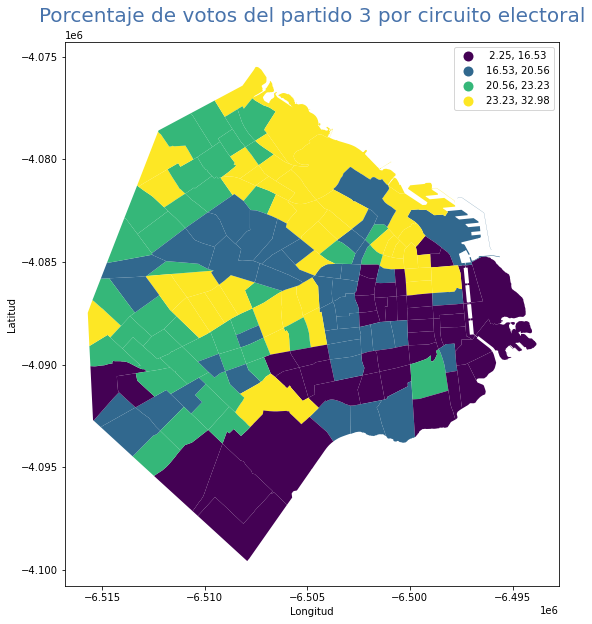

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
 
# Control del título y los ejes
ax.set_title('Porcentaje de votos del partido 3 por circuito electoral', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
 
# Mostrar el mapa finalizado
caba_votos_shp.plot(column='pp3', cmap='viridis',scheme='quantiles', k = 4, legend=True, ax=ax, zorder=5)

Análisis de variables sociodemográficas.

Con los fines de comparar estos resultados electorales con las variables sociodemográficas estructurales, y así poder arribar a un perfil de votantes del partido 3, es que pasamos a analizar la distribución de estas variables en CABA. Para esto, necesitamos de un nuevo geodataframe que nos permita visualizar los resultados del censo por radio censal.

In [19]:
radios_shp = gpd.read_file("/Users/camilaherrero/Desktop/Candidato 3/CABA_radios.shx",
    delimiter=',',       # delimitador ',',';','|','\t'
    header=0,            # número de fila como nombre de columna
    names=None,          # nombre de las columnas (ojo con header)
    index_col=0,         # que col es el índice
    usecols=None,        # que col usar. Ej: [0, 1, 2], ['foo', 'bar', 'baz']
    dtype=None,          # Tipo de col {'a': np.int32, 'b': str} 
    skiprows=None,       # saltear filas al inicio
    skipfooter=0,        # saltear filas al final
    nrows=None,          # n de filas a leer
    decimal='.',         # separador de decimal. Ej: ',' para EU dat
    quotechar='"',       # char para reconocer str
    encoding=None,
      )

radios_shp.rename({"DPTO" : "COMUNA"}, axis = 1, inplace = True) #cambie el nombre de la columna dpto por comuna para poder hacer un merge con el df que veniamos trabajando
radios_shp["COMUNA"] = radios_shp.COMUNA.str.strip("Comuna") #para sacarle la leyenda "Comuna" a la fila de comunas y que quede solo el numero
radios_shp["COMUNA"] = radios_shp["COMUNA"].apply(int)
radios_shp

,RADIO,VULNERABIL,NSE,CENTRO_DE_,HOSPITAL,POSTA_SANI,IDPROV,PROV,IDDPTO,COMUNA,REDCODE,RADIOS_POB,RADIOS_HOG,RADIOS_LAT,RADIOS_LON,RADIOS_SUP,geometry
0,020010101,0.802284,-0.456724,16.348,38.006,105.48,02,Ciudad AutÃ³noma de Buenos Aires,02001,1,020010101,336,65,-34.586689,-58.368836,1.794,"POLYGON ((-58.37430 -34.57870, -58.36801 -34.5..."
1,020010201,0.817588,-0.456724,16.976,46.61,133.978,02,Ciudad AutÃ³noma de Buenos Aires,02001,1,020010201,478,161,-34.578623,-58.386987,0.027,"POLYGON ((-58.38920 -34.57818, -58.38893 -34.5..."
2,020010202,0.820031,-0.456724,18.384,48.838,135.066,02,Ciudad AutÃ³noma de Buenos Aires,02001,1,020010202,401,128,-34.579194,-58.387533,0.018,"POLYGON ((-58.38909 -34.57855, -58.38890 -34.5..."
3,020010203,0.818413,-0.456724,14.448,48.746,131.126,02,Ciudad AutÃ³noma de Buenos Aires,02001,1,020010203,337,104,-34.580158,-58.385503,0.011,"POLYGON ((-58.38603 -34.57947, -58.38508 -34.5..."
4,020010204,0.825755,-0.456724,11.074,50.410000000000004,121.272,02,Ciudad AutÃ³noma de Buenos Aires,02001,1,020010204,602,163,-34.580006,-58.382654,0.136,"POLYGON ((-58.38562 -34.57822, -58.38551 -34.5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3548,020152109,0.082985,0.455652,9.706,12.128,112.78,02,Ciudad AutÃ³noma de Buenos Aires,02015,15,020152109,863,392,-34.599727,-58.431162,0.020,"POLYGON ((-58.43221 -34.59950, -58.43113 -34.5..."
3549,020152110,0.073872,0.520911,7.61,13.622,113.328,02,Ciudad AutÃ³noma de Buenos Aires,02015,15,020152110,613,278,-34.598933,-58.430166,0.016,"POLYGON ((-58.43113 -34.59880, -58.43006 -34.5..."
3550,020152111,0.076228,0.530775,8.342,14.754,113.234,02,Ciudad AutÃ³noma de Buenos Aires,02015,15,020152111,697,335,-34.598226,-58.429006,0.018,"POLYGON ((-58.43006 -34.59811, -58.42899 -34.5..."
3551,020152112,0.193413,0.306683,9.968,17.104,113.058,02,Ciudad AutÃ³noma de Buenos Aires,02015,15,020152112,510,217,-34.597576,-58.427811,0.020,"POLYGON ((-58.42899 -34.59743, -58.42784 -34.5..."


A continuación, retomamos el dataframe con los resultados del censo de los votantes de CABA y le aplicamos una serie de operaciones para lograr unir los datos del censo con los radios censales.

In [20]:
votantes["PROV"] = 2
votantes
# %%
votantes["COMUNA"] = votantes["COMUNA"].apply(str)
votantes["COMUNA"]
# %%
votantes["IDFRAC"] = votantes["IDFRAC"].apply(str)
# %%
votantes["IDRADIO"] = votantes["IDRADIO"].apply(str)

# %%
votantes["PROV"] = votantes["PROV"].apply(str)
# %%
votantes["COMUNA"] = votantes["COMUNA"].str.pad(3, side = "left", fillchar ='0')
votantes["COMUNA"]
# %%
votantes["IDFRAC"] = votantes["IDFRAC"].str.pad(2, side = "left", fillchar ='0')
votantes["IDFRAC"]
# %%
votantes["IDRADIO"] = votantes["IDRADIO"].str.pad(2, side = "left", fillchar ='0')
votantes["IDRADIO"]

# %%
votantes["PROV"] = votantes["PROV"].str.pad(2, side = "left", fillchar ='0')
votantes["PROV"]
# %%
votantes
# %%
votantes["RADIO"] = votantes.PROV.str.cat(votantes.COMUNA)
votantes
# %%
votantes["RADIO"] = votantes.RADIO.str.cat(votantes.IDFRAC)
votantes
# %%
votantes["RADIO"] = votantes.RADIO.str.cat(votantes.IDRADIO)
votantes

/var/folders/l2/dnldqmpn36q_2tbrlwy8wnw40000gn/T/ipykernel_966/837075708.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  votantes["PROV"] = 2
/var/folders/l2/dnldqmpn36q_2tbrlwy8wnw40000gn/T/ipykernel_966/837075708.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  votantes["COMUNA"] = votantes["COMUNA"].apply(str)
/var/folders/l2/dnldqmpn36q_2tbrlwy8wnw40000gn/T/ipykernel_966/837075708.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

,COMUNA,NOMDPTO,FRAC_REF_ID,IDFRAC,RADIO_REF_ID,IDRADIO,VIVIENDA_REF_ID,TIPVV,V01,V02,...,P07,P12,EDADAGRU,EDADQUI,P08,P09,P10,CONDACT,PROV,RADIO
0,001,Comuna 01 ...,1,01,1,01,1,1,1,1,...,1,2,2,13,2,4,2,1,02,020010101
1,001,Comuna 01 ...,1,01,1,01,1,1,1,1,...,1,1,2,10,2,4,1,1,02,020010101
2,001,Comuna 01 ...,1,01,1,01,1,1,1,1,...,1,1,3,14,2,7,2,1,02,020010101
3,001,Comuna 01 ...,1,01,1,01,1,1,1,1,...,1,1,2,13,2,6,1,3,02,020010101
4,001,Comuna 01 ...,1,01,1,01,1,1,1,1,...,1,1,2,5,1,4,2,1,02,020010101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2890146,015,Comuna 15 ...,351,21,3553,13,1426438,2,0,0,...,1,0,3,20,2,2,1,0,02,020152113
2890147,015,Comuna 15 ...,351,21,3553,13,1426438,2,0,0,...,1,0,3,19,2,6,1,0,02,020152113
2890148,015,Comuna 15 ...,351,21,3553,13,1426438,2,0,0,...,1,0,3,17,2,2,1,0,02,020152113
2890149,015,Comuna 15 ...,351,21,3553,13,1426438,2,0,0,...,1,0,3,18,2,2,1,0,02,020152113


Una vez que unimos estos dataframe, podemos pasar a analizar la distribución de ciertas variables que consideramos de interés.

Para poder calcular los porcentajes de cada variable por radio es fundamental asignar a una variable el total de personas por radio.

In [21]:
totpersxradio = votantes[["RADIO","TOTPERS"]].groupby(["RADIO"]).count()
totpersxradio

,TOTPERS
RADIO,
020010101,273
020010201,308
020010202,239
020010203,209
020010204,358
...,...
020152109,723
020152110,501
020152111,579


Ahora sí, en primer lugar, vamos a analizar la distribución de estudiantes universitarios en CABA. Para facilitar la interpretación realizamos una división en quantiles donde cada color demuestra donde se encuentra el 25% de la población.

In [22]:
universitario = votantes.loc[((votantes["P09"] == 7) & (votantes["P10"] == 2) & (votantes["P03"] <30 ))]
universitario
# %%
universitario = universitario.loc[:,["P09", "P10", "RADIO"]]
universitario

# %%
universitario = universitario.groupby(["RADIO"]).count()
universitario
# %%
universitario.reset_index(inplace= True)
universitario

# %%
universitario = pd.merge(universitario, totpersxradio, on = "RADIO", how = "inner")
universitario 
# %%
universitario["% sobre totpers x radio"] = universitario.apply(
    (lambda x: (x["P09"] + 0.0) / x["TOTPERS"] * 100), axis=1
)
universitario


,RADIO,P09,P10,TOTPERS,% sobre totpers x radio
0,020010101,12,12,273,4.395604
1,020010201,7,7,308,2.272727
2,020010202,5,5,239,2.092050
3,020010203,4,4,209,1.913876
4,020010204,13,13,358,3.631285
...,...,...,...,...,...
3541,020152109,83,83,723,11.479945
3542,020152110,37,37,501,7.385230
3543,020152111,34,34,579,5.872193
3544,020152112,26,26,420,6.190476


<AxesSubplot:title={'center':'Universitarios'}, xlabel='Longitud', ylabel='Latitud'>

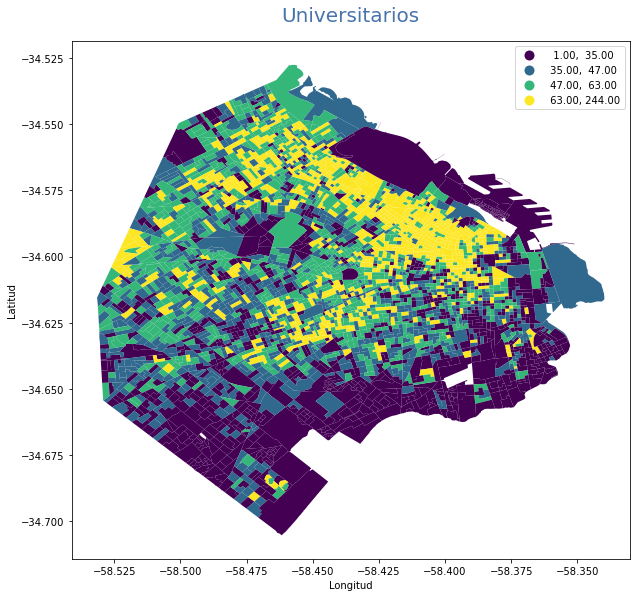

In [36]:
uni_radio_shp = pd.merge(radios_shp,universitario, on="RADIO", how="inner")
uni_radio_shp
# %%
fig, ax = plt.subplots(figsize=(10, 10))
 
# Control del título y los ejes
ax.set_title('Universitarios', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
uni_radio_shp.plot(column='P09', cmap='viridis',scheme='quantiles', k = 4, legend=True, ax=ax, zorder=5)

Analizando la distribución de estudiantes universitarios en CABA, podemos intentar profundizar el análisis y visualizar la distribución de personas que eectivamente terminaron el nivel universitario de educación.  

In [37]:
termino_universidad = votantes.loc[((votantes["P09"] == 7) & (votantes["P10"] == 1))] #Seleccionamos a los que terminaron univerisdad

termino_universidad = termino_universidad.loc[:,["P09", "P10", "RADIO"]]
termino_universidad

# %%
termino_universidad = termino_universidad.groupby(["RADIO"]).count()
termino_universidad
# %%
termino_universidad.reset_index(inplace= True)
termino_universidad

# %%
termino_universidad = pd.merge(termino_universidad, totpersxradio, on = "RADIO", how = "inner")
termino_universidad 
# %%
termino_universidad["% sobre totpers x radio"] = termino_universidad.apply(
    (lambda x: (x["P09"] + 0.0) / x["TOTPERS"] * 100), axis=1
)
termino_universidad

,RADIO,P09,P10,TOTPERS,% sobre totpers x radio
0,020010101,11,11,273,4.029304
1,020010201,7,7,308,2.272727
2,020010202,2,2,239,0.836820
3,020010203,3,3,209,1.435407
4,020010204,1,1,358,0.279330
...,...,...,...,...,...
3544,020152109,123,123,723,17.012448
3545,020152110,112,112,501,22.355289
3546,020152111,163,163,579,28.151986
3547,020152112,56,56,420,13.333333


<AxesSubplot:title={'center':'Termino la universidad'}, xlabel='Longitud', ylabel='Latitud'>

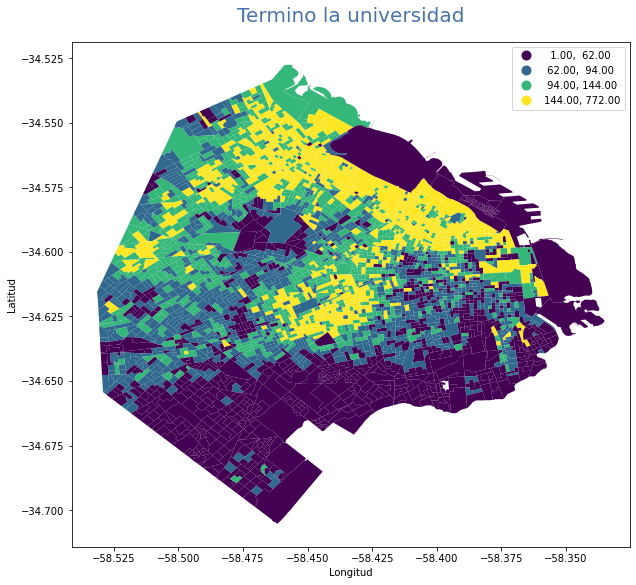

In [38]:
recibido_radio_shp = pd.merge(radios_shp,termino_universidad, on="RADIO", how="inner")
recibido_radio_shp

fig, ax = plt.subplots(figsize=(10, 10))
 
# Control del título y los ejes
ax.set_title('Termino la universidad', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
recibido_radio_shp.plot(column='P09', scheme='quantiles', k = 4, legend=True, ax=ax, zorder=5)

A continuación, vamos a analizar la distribución de personas que no terminaron el nivel secundario de educación en CABA y tienen más de 20 años.

In [24]:
no_secundario = votantes.loc[((votantes["P09"] == 4) & (votantes["P10"] == 2) & (votantes["P03"] >20 ))] 

no_secundario = no_secundario.loc[:,["P09", "P10", "RADIO"]]
no_secundario

# %%
no_secundario = no_secundario.groupby(["RADIO"]).count()
no_secundario
# %%
no_secundario.reset_index(inplace= True)
no_secundario

# %%
no_secundario = pd.merge(no_secundario, totpersxradio, on = "RADIO", how = "inner")
no_secundario 

# %%
no_secundario["% sobre totpers x radio"] = no_secundario.apply(
    (lambda x: (x["P09"] + 0.0) / x["TOTPERS"] * 100), axis=1
)
no_secundario

,RADIO,P09,P10,TOTPERS,% sobre totpers x radio
0,020010101,31,31,273,11.355311
1,020010201,65,65,308,21.103896
2,020010202,51,51,239,21.338912
3,020010203,42,42,209,20.095694
4,020010204,90,90,358,25.139665
...,...,...,...,...,...
3547,020152109,58,58,723,8.022130
3548,020152110,39,39,501,7.784431
3549,020152111,29,29,579,5.008636
3550,020152112,54,54,420,12.857143


<AxesSubplot:title={'center':'No terminaron el secundario y tienen más de 20'}, xlabel='Longitud', ylabel='Latitud'>

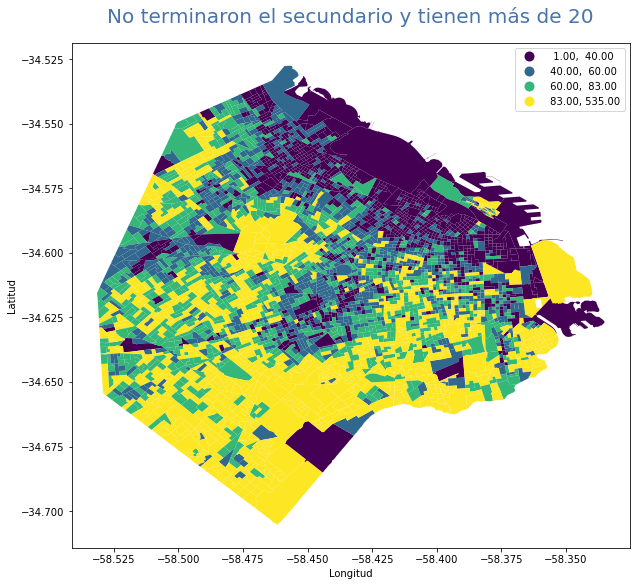

In [25]:
nosec_radio_shp = pd.merge(radios_shp,no_secundario, on="RADIO", how="inner")
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('No terminaron el secundario y tienen más de 20', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
nosec_radio_shp.plot(column='P09',scheme='quantiles', k = 4, legend=True, ax=ax, zorder=5)

Continuando con el análisis sobre el nivel educativo, pasamos a analizar la distribución de personas que únicamente cursaron el nivel primario.

In [26]:
primario_ = votantes.loc[:,"P09"] == 2
primario = votantes[primario_]

primario = primario.loc[:,["P09", "RADIO"]]
primario

# %%
primario = primario.groupby(["RADIO"]).count()
primario
# %%
primario.reset_index(inplace= True)
primario

# %%
primario = pd.merge(primario, totpersxradio, on = "RADIO", how = "inner")
primario 

# %%
primario["% sobre totpers x radio"] = primario.apply(
    (lambda x: (x["P09"] + 0.0) / x["TOTPERS"] * 100), axis=1
)
primario

,RADIO,P09,TOTPERS,% sobre totpers x radio
0,020010101,50,273,18.315018
1,020010201,117,308,37.987013
2,020010202,105,239,43.933054
3,020010203,71,209,33.971292
4,020010204,122,358,34.078212
...,...,...,...,...
3547,020152109,89,723,12.309820
3548,020152110,61,501,12.175649
3549,020152111,61,579,10.535406
3550,020152112,69,420,16.428571


<AxesSubplot:title={'center':'Únicamente nivel de educación primaria'}, xlabel='Longitud', ylabel='Latitud'>

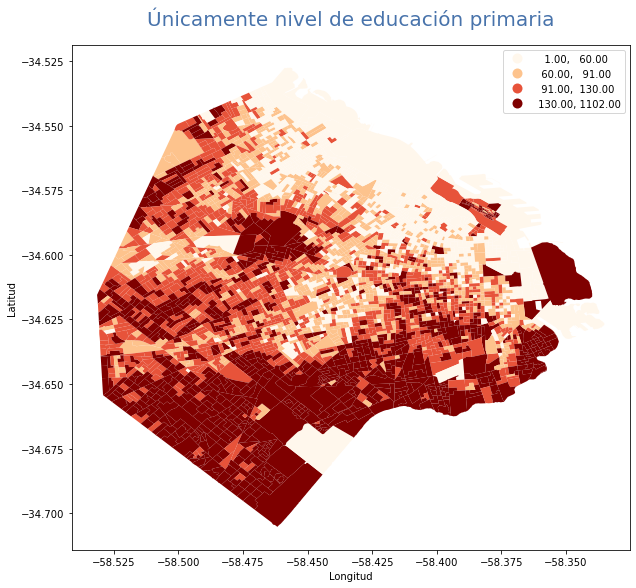

In [27]:
prim_radio_shp = pd.merge(radios_shp,primario, on="RADIO", how="inner")


fig, ax = plt.subplots(figsize=(10, 10))
 
# Control del título y los ejes
ax.set_title('Únicamente nivel de educación primaria', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
prim_radio_shp.plot(column='P09', cmap='OrRd',scheme='quantiles', k = 4, legend=True, ax=ax, zorder=5)

Luego analizamos donde se encuentran los hogares con hacinamiento, considerando a los mismos como los que tienen más de 2 personas por habitación.

In [28]:
hacinado_ = votantes.loc[:,"INDHAC"] == 6
hacinados = votantes[hacinado_]
hacinados
 

hacinados = hacinados.loc[:,["INDHAC", "RADIO"]]
hacinados

# %%
hacinados = hacinados.groupby(["RADIO"]).count()
hacinados
# %%
hacinados.reset_index(inplace= True)
hacinados

# %%
hacinados = pd.merge(hacinados, totpersxradio, on = "RADIO", how = "inner")
hacinados 

# %%
hacinados["% sobre totpers x radio"] = hacinados.apply(
    (lambda x: (x["INDHAC"] + 0.0) / x["TOTPERS"] * 100), axis=1
)
hacinados

,RADIO,INDHAC,TOTPERS,% sobre totpers x radio
0,020010101,64,273,23.443223
1,020010201,31,308,10.064935
2,020010202,47,239,19.665272
3,020010203,19,209,9.090909
4,020010204,32,358,8.938547
...,...,...,...,...
2754,020152109,2,723,0.276625
2755,020152110,7,501,1.397206
2756,020152111,11,579,1.899827
2757,020152112,32,420,7.619048


<AxesSubplot:title={'center':'Hacinados'}, xlabel='Longitud', ylabel='Latitud'>

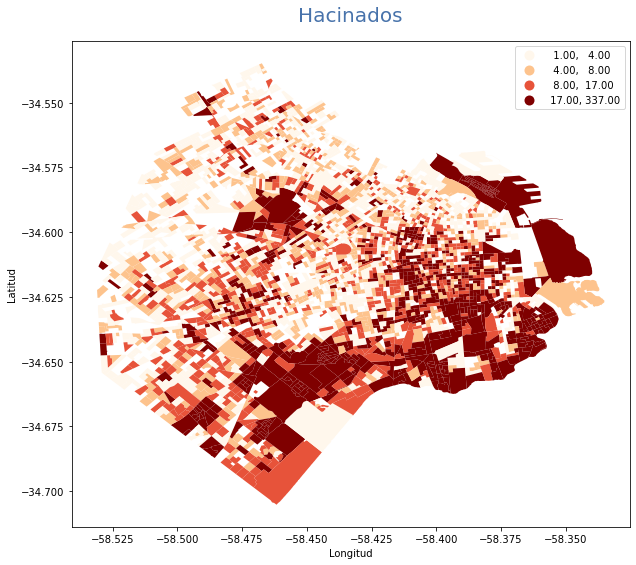

In [29]:
# %%
hac_radio_shp = pd.merge(radios_shp,hacinados, on="RADIO", how="inner")
hac_radio_shp

fig, ax = plt.subplots(figsize=(10, 10))
 
# Control del título y los ejes
ax.set_title('Hacinados', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
hac_radio_shp.plot(column='INDHAC', cmap='OrRd',scheme='quantiles', k = 4, legend=True, ax=ax, zorder=5)

Pasamos a analizar la distribución de personas jóvenes, entre 18 y 27 años.

In [30]:
jovenes_ = votantes.loc[:,"P03"] < 27
jovenes = votantes[jovenes_]

jovenes = jovenes.loc[:,["P03", "RADIO"]]
jovenes

# %%
jovenes = jovenes.groupby(["RADIO"]).count()
jovenes
# %%
jovenes.reset_index(inplace= True)
jovenes

# %%
jovenes = pd.merge(jovenes, totpersxradio, on = "RADIO", how = "inner")
jovenes 

# %%
jovenes["% sobre totpers x radio"] = jovenes.apply(
    (lambda x: (x["P03"] + 0.0) / x["TOTPERS"] * 100), axis=1
)
jovenes

,RADIO,P03,TOTPERS,% sobre totpers x radio
0,020010101,87,273,31.868132
1,020010201,106,308,34.415584
2,020010202,79,239,33.054393
3,020010203,70,209,33.492823
4,020010204,126,358,35.195531
...,...,...,...,...
3547,020152109,113,723,15.629322
3548,020152110,69,501,13.772455
3549,020152111,77,579,13.298791
3550,020152112,83,420,19.761905


<AxesSubplot:title={'center':'Jóvenes de 18 a 27 '}, xlabel='Longitud', ylabel='Latitud'>

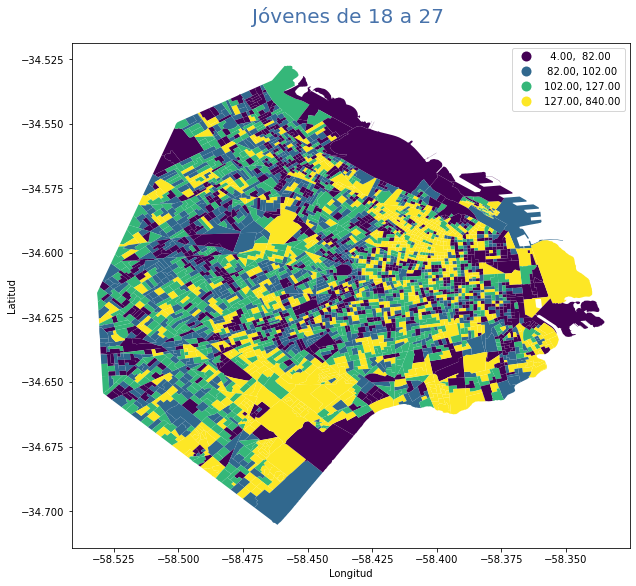

In [31]:
jov_radio_shp = pd.merge(radios_shp,jovenes, on="RADIO", how="inner")


fig, ax = plt.subplots(figsize=(10, 10))
 
# Control del título y los ejes
ax.set_title('Jóvenes de 18 a 27 ', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
jov_radio_shp.plot(column='P03',scheme='quantiles', k = 4, legend=True, ax=ax, zorder=5)

Ahora, analizamos la distribución de personas mayores de 55 años.

In [32]:
nojovenes_ = votantes.loc[:,"P03"] > 55
nojovenes = votantes[nojovenes_]

nojovenes = nojovenes.loc[:,["P03", "RADIO"]]
nojovenes

# %%
nojovenes = nojovenes.groupby(["RADIO"]).count()
nojovenes
# %%
nojovenes.reset_index(inplace= True)
nojovenes

# %%
nojovenes = pd.merge(nojovenes, totpersxradio, on = "RADIO", how = "inner")
nojovenes 

# %%
nojovenes["% sobre totpers x radio"] = nojovenes.apply(
    (lambda x: (x["P03"] + 0.0) / x["TOTPERS"] * 100), axis=1
)
nojovenes

,RADIO,P03,TOTPERS,% sobre totpers x radio
0,020010101,24,273,8.791209
1,020010201,30,308,9.740260
2,020010202,24,239,10.041841
3,020010203,20,209,9.569378
4,020010204,35,358,9.776536
...,...,...,...,...
3547,020152109,238,723,32.918396
3548,020152110,153,501,30.538922
3549,020152111,159,579,27.461140
3550,020152112,120,420,28.571429


<AxesSubplot:title={'center':'Mayores de 55'}, xlabel='Longitud', ylabel='Latitud'>

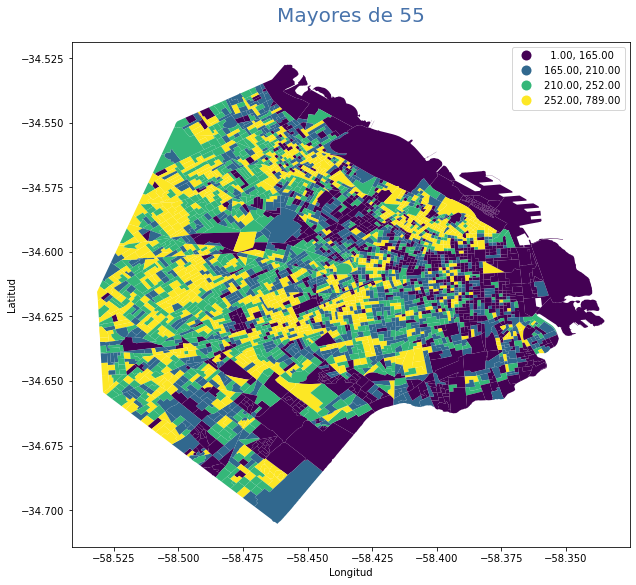

In [33]:
njov_radio_shp = pd.merge(radios_shp,nojovenes, on="RADIO", how="inner")


fig, ax = plt.subplots(figsize=(10, 10))
 
# Control del título y los ejes
ax.set_title('Mayores de 55', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
njov_radio_shp.plot(column='P03',scheme='quantiles', k = 4, legend=True, ax=ax, zorder=5)

Ahora, pasamos a analizar la distribución de desempleados por radios censales en CABA.

In [34]:
is_desempleado = votantes.loc[:,"CONDACT"] == 2
desempleados = votantes[is_desempleado]

desempleados = desempleados.loc[:,["CONDACT", "RADIO"]]
desempleados

# %%
desempleados = desempleados.groupby(["RADIO"]).count()
desempleados
# %%
desempleados.reset_index(inplace= True)
desempleados

# %%
desempleados = pd.merge(desempleados, totpersxradio, on = "RADIO", how = "inner")
desempleados 

# %%
desempleados["% sobre totpers x radio"] = desempleados.apply(
    (lambda x: (x["CONDACT"] + 0.0) / x["TOTPERS"] * 100), axis=1
)
desempleados

,RADIO,CONDACT,TOTPERS,% sobre totpers x radio
0,020010101,7,273,2.564103
1,020010201,11,308,3.571429
2,020010202,14,239,5.857741
3,020010203,15,209,7.177033
4,020010204,18,358,5.027933
...,...,...,...,...
3543,020152109,20,723,2.766252
3544,020152110,12,501,2.395210
3545,020152111,15,579,2.590674
3546,020152112,13,420,3.095238


<AxesSubplot:title={'center':'Desempleados'}, xlabel='Longitud', ylabel='Latitud'>

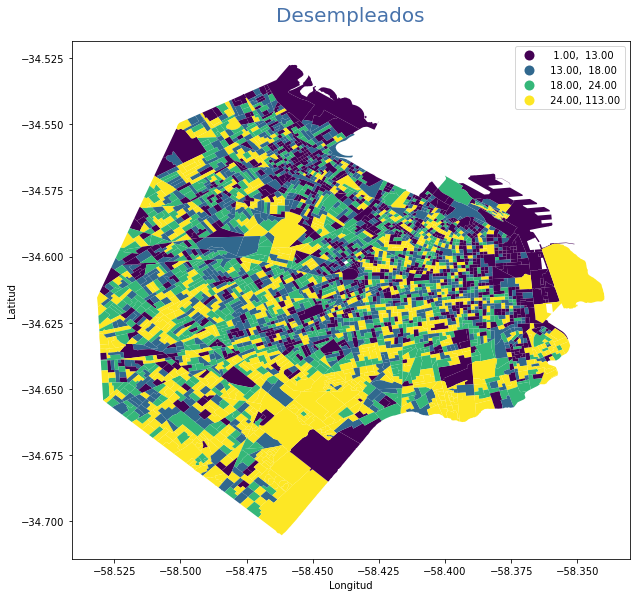

In [35]:
des_radio_shp = pd.merge(radios_shp,desempleados, on="RADIO", how="inner")

fig, ax = plt.subplots(figsize=(10, 10))
 
# Control del título y los ejes
ax.set_title('Desempleados', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': '#4873ab'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
des_radio_shp.plot(column='CONDACT',scheme='quantiles', k = 4, legend=True, ax=ax, zorder=5)